$$\textrm{Joaquin Peñuela Parra}$$
$$\textrm{University of Los Andes}$$
$$\textrm{High Energy Physics Group: Phenomenology of Particles}$$

This code was written to be running in Docker. If you do not have a Docker inside hep-server2 please refer to: https://github.com/Phenomenology-group-uniandes/Tutoriales_Generales

$\textbf{Preliminaries}$ 

The libraries used here are:

In [1]:
import os
import subprocess
import numpy as np
import pandas as pd
from itertools import product
from ROOT import TCanvas, TLegend, TLatex

## IMPORTANT: Make sure that "Uniandes_Framework" is in .gitignore
framework_path = "Uniandes_Framework"

if os.path.exists(framework_path):
    # Pull updates if the framework is already cloned
    try:
        subprocess.run(["git", "-C", framework_path, "pull"])
    except subprocess.CalledProcessError as e:
        raise Exception(f"Error occurred while pulling updates from the framework: {e}")
else:
    # Clone the framework if it is not already cloned
    try:
        subprocess.run(["git", "clone", "git@github.com:Phenomenology-group-uniandes/Uniandes_Framework.git"])
    except subprocess.CalledProcessError as e:
        raise Exception(f"Error occurred while cloning the framework: {e}")
from Uniandes_Framework.delphes_reader.lhereader import LHE_Loader, readLHEF, get_event_by_child
from Uniandes_Framework.delphes_reader.root_analysis import get_kinematics_row, make_histograms, overlap_histos, Quiet, generate_csv, sum_histos, histos_matplotlib, write_root_file, write_txt_file_with_high_per_bin

Welcome to JupyROOT 6.22/06


hint: Pulling without specifying how to reconcile divergent branches is
hint: discouraged. You can squelch this message by running one of the following
hint: commands sometime before your next pull:
hint: 
hint:   git config pull.rebase false  # merge (the default strategy)
hint:   git config pull.rebase true   # rebase
hint:   git config pull.ff only       # fast-forward only
hint: 
hint: You can replace "git config" with "git config --global" to set a default
hint: preference for all repositories. You can also pass --rebase, --no-rebase,
hint: or --ff-only on the command line to override the configured default per
hint: invocation.


Already up to date.


In [2]:
Folder = 'Data_Parton_Level'

Betards = ['woRHC']
zp_limits = ['zp_upper_limit', 'zp_lower_limit']

In [3]:
generation_options = {'ta_ta_virtual_contribution':  'generate p p > ta ta QED = 0 / zp', 
                      'ta_ta_real_contribution': 'generate p p > zp, zp > ta ta QED = 0',
                      'ta_ta_total_contribution': 'generate p p > ta ta QED = 0'}

In [4]:
M_Us = np.arange(1000,3500,500)
g_Us = [1.0]
g_Zps = [2.25]

In [5]:
def read_xs_from_html(signal, mu_gu_gzp_label, Betard, zp_limit):
    html_path = os.path.join(os.getcwd(), Folder, Betard, zp_limit, signal,  mu_gu_gzp_label, 'crossx.html')
    html_table = pd.read_html(html_path)
    column_xs = html_table[0]['Cross section (pb)']
    return float(column_xs[0].split(' ')[0])    

In [6]:
generation_options = {'ta_ta_virtual_contribution':  'generate p p > ta ta QED = 0 $$ zp', 
                      'ta_ta_real_contribution': 'generate p p > zp > ta ta QED = 0',
                      'ta_ta_total_contribution': 'generate p p > ta ta QED = 0'}

In [7]:
Kinematic_information = {'woRHC':{'zp_upper_limit':{}, 'zp_lower_limit':{}}}

for mu , gu, gzp, Betard, zp_limit in product(M_Us,g_Us, g_Zps, Betards, zp_limits): #It takes 3 minutes by combination
    
    label = f'mu_{mu}_gu_{gu}_gzp_{gzp}'
    Kinematic_information[Betard][zp_limit][label] = {}
    
    for signal in generation_options.keys(): 
        
        CSV_File_path = os.path.join(Folder, Betard, zp_limit, signal, label, 'Kinematic_Information.csv')
        Kinematic_information[Betard][zp_limit][label][signal] = pd.read_csv(CSV_File_path)

In [8]:
default_hist_bins_dict={"m_ll(GeV)" : [100, 0, 5000.0]}

In [11]:
format_figure = '.png'
# format_figure = '.pdf'

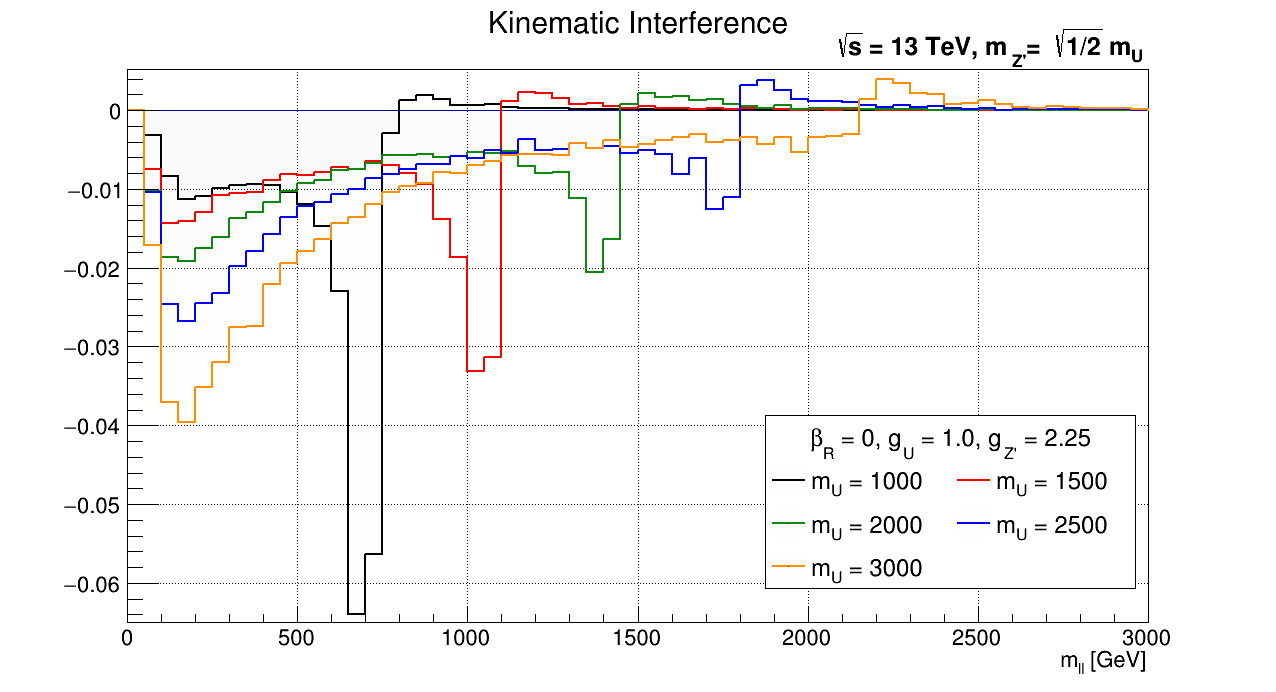

In [12]:
Histograms = {'woRHC':{'zp_upper_limit':{}, 'zp_lower_limit':{}}}

for mu , gu, gzp, Betard, zp_limit in product(M_Us,g_Us, g_Zps, Betards, zp_limits):
    
    label = f'mu_{mu}_gu_{gu}_gzp_{gzp}'
          
    #Normalized by XS:
    H_Total = make_histograms(Kinematic_information[Betard][zp_limit][label]['ta_ta_total_contribution'], hist_bins_dict = default_hist_bins_dict, integral = read_xs_from_html('ta_ta_total_contribution', label, Betard, zp_limit))
    H_Virtual = make_histograms(Kinematic_information[Betard][zp_limit][label]['ta_ta_virtual_contribution'], hist_bins_dict = default_hist_bins_dict, integral = read_xs_from_html('ta_ta_virtual_contribution', label, Betard, zp_limit))
    H_Real = make_histograms(Kinematic_information[Betard][zp_limit][label]['ta_ta_real_contribution'], hist_bins_dict = default_hist_bins_dict, integral = read_xs_from_html('ta_ta_real_contribution', label, Betard, zp_limit))

    H_Sum = sum_histos([H_Virtual["m_ll(GeV)"], H_Real["m_ll(GeV)"]])
    H_Division = H_Sum/H_Total["m_ll(GeV)"]
    Histograms[Betard][zp_limit][str(mu)] =  {"m_ll(GeV)": sum_histos([H_Total["m_ll(GeV)"], H_Sum], substract = True)}

os.makedirs(os.path.join('Article_Histograms'), exist_ok=True)

ROOT_COLORS = [1,2,209,4,94,226,6] #https://root-forum.cern.ch/t/what-is-your-best-way-to-increment-colors/13809
zp_label = {'zp_upper_limit': "m_{Z'}= #sqrt{3/2} m_{U}", 'zp_lower_limit':"m_{Z'}= #sqrt{1/2} m_{U}"}

for Betard, zp_limit in product(Betards, zp_limits): #It takes 3 minutes by combination
    
    with Quiet():
    
        histos, canvas, legend = overlap_histos("m_ll(GeV)", dict_histos= Histograms[Betard][zp_limit])
        
        canvas = TCanvas('','', 1280, 720)
        legend = TLegend(0.6, .15, 0.89, .4)
        legend.SetNColumns(2)
        legend.SetLineWidth(1)
        legend.SetHeader("#beta_{R} = 0, g_{U} = 1.0, g_{Z'} = 2.25","C")
        
        for n, histo in enumerate(histos):
            
            label = f'mu_{list(Histograms[Betard][zp_limit].keys())[n]}_gu_1.0_gzp_2.25'
            histo.Scale(1/read_xs_from_html('ta_ta_total_contribution', label, Betard, zp_limit))
            
            histo.SetLineColor(ROOT_COLORS[n])           
            histo.SetFillColorAlpha(ROOT_COLORS[n], 0.00)    
                
            if 'lower' in zp_limit: 
                histo.GetYaxis().SetRangeUser(-0.065,0.005)
                histos.GetXaxis().SetLimits(0,3000)
            else: histo.GetYaxis().SetRangeUser(-0.88,0.025)
        
            legend.AddEntry(histo, 'm_{U} = ' + list(Histograms[Betard][zp_limit].keys())[n])
            
        histos.SetTitle('Kinematic Interference; m_{ll} [GeV];')
        histos.Draw("histnostack")
        legend.Draw('same')
        
        latex = TLatex()
        latex.SetNDC()
        latex.SetTextSize(0.04)
        latex.DrawLatex(0.655,0.92,'#sqrt{s} = 13 TeV, ' + zp_label[zp_limit])
        
        canvas.SetGrid()
        canvas.Draw() 
        canvas.SaveAs(f'Article_Histograms/Kinematic_Interference_{zp_limit}_{Betard}{format_figure}') 